# Implementation of basic DEBABM

In [1]:
@time "Loading packages" begin
    using Pkg; Pkg.activate("../test")
    TAG = splitpath(@__FILE__)[end] |> x -> split(x, ".")[1] |> String    
    using Test

    using Plots, StatsPlots, Plots.Measures
    default(leg = false, lw = 1.5)
    
    using SHUtils
    using DataFrames, DataFramesMeta
    using ProgressMeter
    using Distributions
    using ComponentArrays
    using StaticArrays
    using Parameters, DEBParamStructs
    using Random
    using DEBFigures
    using Revise

    include(("../src/Params.jl"));
end

  Activating project at `c:\Users\simon\Documents\Julia\DEBBase.jl\test`


Loading packages: 10.148874 seconds (11.20 M allocations: 667.112 MiB, 5.24% gc time, 16.90% compilation time: 9% of which was recompilation)


agent_variability!

## Agent definition

In [2]:
"""
Macro to initialize parameter structure with Id = 1. 
Usage: 
```
@agent struct Params(NoSpaceAgent)
    x = 1
end

p = @init Params
```
"""
macro init(type)
    quote
        $type(id = 1)
    end
end

@init

In [3]:
@enum CauseOfDeath none starvation chemical

In [4]:
using DoseResponse

In [5]:
using Agents, StatsBase

"""
DEB agent
"""
@agent struct DEBAgent(NoSpaceAgent)
    spc::SpeciesParams # species params
    agn::AgentParams # agent params

    X_emb::Float64 = agn.X_emb_int # initial mass of vitellus
    S::Float64 = agn.X_emb_int * X_EMB_INT_REL # initial structure is a small fraction of initial reserve // mass of vitellus
    Sdot::Float64 = 0. # somatic growth rate
    H::Float64 = 0 # maturity
    Hdot::Float64 = 0 # maturation flux
    R::Float64 = 0 # reproduction buffer
    Rdot::Float64 = 0 # reproduction flux
    f_X::Float64 = 1 # scaled functional response 
    I::Float64 = 0 # cumlative ingestion
    Idot::Float64 = 0 # ingestion flux
    A::Float64 = 0 # cumulative assimilation
    Adot::Float64 = 0 # assimilation flux
    M::Float64 = 0 # cumulative somatic maintenance
    Mdot::Float64 = 0 # somatic maintenance flux
    J::Float64 = 0 # cumulative maturity maintenance 
    Jdot::Float64 = 0 # maturity maintenance flux
    Q::Float64 = 0 # cumulative dissipation

    D_G = MVector{length(spc.k_D_G), Float64}(zeros(length(spc.k_D_G))) # scaled damage | growth efficiency
    D_M = MVector{length(spc.k_D_G), Float64}(zeros(length(spc.k_D_G))) # scaled damage | maintenance costs 
    D_A = MVector{length(spc.k_D_G), Float64}(zeros(length(spc.k_D_G))) # scaled damage | assimilation efficiency
    D_R = MVector{length(spc.k_D_G), Float64}(zeros(length(spc.k_D_G))) # scaled damage | reproduction efficiency
    D_h = MVector{length(spc.k_D_G), Float64}(zeros(length(spc.k_D_G))) # scaled damage | hazard rate

    y_G::Float64 = 1. # relative response | growth efficiency
    y_M::Float64 = 1. # relative response | maintenance costs 
    y_A::Float64 = 1. # relative response | assimilation efficiency
    y_R::Float64 = 1. # relative response | reproduction efficiency
    h_z::Float64 = 0. # hazard rate | chemical stressors
    h_S::Float64 = 0.  # hazard rate | starvation

    cum_repro::Float64 = 1
    age::Float64 = 0.
    cohort::Float64 = 0
    dead::Float64 = 0
    causeofdeath::CauseOfDeath = none
end

In [6]:
X_EMB_INT_REL = 1e-3

0.001

## Model initialization

In [7]:
"""
Initialize the DEBABM model from a set of DEBABMParams.
"""
function init_model(glb::GlobalParams, spc::SpeciesParams; dt = 1/24)

    @assert length(spc.k_D_G) >= length(glb.C_W) "Number of TK parameters not unifiable with number of stressors"
    @assert length(spc.drc_functs_G) >= length(glb.C_W) "Number of DRC_functs not unifiable with number of stressors"
    
    properties = Dict()

    # add all the global parameters as model properties
    for field in fieldnames(GlobalParams) 
        properties[field] = getproperty(glb, field)
    end

    properties[:spc] = spc
    properties[:dt] = dt
    properties[:t] = 0.

    properties[:X_p] = glb.X_pdot_in
    properties[:X_pdot] = 0. 
    properties[:X_V] = glb.X_pdot_in / glb.V_patch
    properties[:C_W] = glb.C_W
    properties[:N_tot] = glb.N0

    model = StandardABM(DEBAgent; agent_step!, model_step!, properties)

    for i in 1:glb.N0
        agent = DEBAgent(id = 1, spc = spc, agn = AgentParams(spc))
        add_agent!(agent, model)
    end

    return model
end

init_model

## Stepping functions

In [8]:
"""
Calculate global resource flux terms
"""
function resource_dynamics!(model)
    model.X_pdot = model.X_pdot_in - model.k_X_out * model.X_p
end

"""
Update model state variables
"""
function update!(model)
    model.X_p = max(0, model.X_p + model.X_pdot * model.dt)
    model.t += model.dt
end

"""
Execute a model step
"""
function model_step!(model)
    resource_dynamics!(model)
    update!(model)
end

"""
Ingestion flux
"""
function Idot!(agent, model)    
    if agent.X_emb > 0 # ingestion from vitellus for embryos
        agent.Idot = (Complex(agent.S)^(2/3)).re * agent.agn.Idot_max_rel
    else # ingestion from external resource for other life stages
        agent.f_X = (model.X_p/model.V_patch) / ((model.X_V/model.V_patch) + agent.spc.K_X)
        agent.Idot = agent.f_X * (Complex(agent.S)^(2/3)).re * agent.agn.Idot_max_rel
    end
end

"""
Assimilation flux
"""
function Adot!(agent, model)
    agent.Adot = agent.I * agent.spc.eta_IA * agent.y_A
end

"""
Somatic maintenance flux
"""
function Mdot!(agent, model)
    agent.Mdot = agent.S * agent.spc.k_M * agent.y_M
end

"""
Maturity maintenance flux
"""
function Jdot!(agent, model)
    agent.Jdot = agent.H * agent.spc.k_J * agent.y_M
end

"""
Somatic growth
"""
function Sdot!(agent, model)
    if agent.spc.kappa * agent.Adot >= agent.Mdot # maintenance costs covered? => positive growth =
        agent.Sdot = agent.spc.eta_AS * agent.y_G * (agent.spc.kappa * agent.Adot - agent.Mdot)
    else # maintenance costs not covered? => shrinking
        agent.Sdot -= agent.Mdot / agent.spc.eta_SA - agent.spc.kappa * agent.Adot
    end
end

"""
Maturation
"""
function Hdot!(agent, model)
    if agent.H < agent.agn.H_p
        agent.Hdot = max(0, (1 - agent.spc.kappa) * agent.Adot - agent.Jdot)
    else
        agent.Hdot = 0.
    end
end

"""
Reproduction flux
"""
function Rdot!(agent, model)
    if agent.H >= agent.agn.H_p
        agent.Rdot = max(0, agent.y_A *((1 - agent.spc.kappa) * agent.Adot - agent.Jdot))
    else
        agent.Rdot = 0.
    end
end

"""
Update agent state variables
"""
function update!(agent, model)
    if agent.X_emb > 0
        agent.X_emb = max(0, -agent.Idot * model.dt)
    else
        model.X_p = max(0, -agent.Idot * model.dt)
    end
    
    agent.I = max(0, agent.I + agent.Idot * model.dt)
    agent.A = max(0, agent.A + agent.Adot * model.dt)
    agent.M = max(0, agent.M + agent.Mdot * model.dt)
    agent.J = max(0, agent.J + agent.Jdot * model.dt)
    agent.H = max(0, agent.H + agent.Hdot * model.dt)
    agent.R = max(0, agent.R + agent.Rdot * model.dt)
end

function vBGrowth!(agent, model)
    agent.S = agent.S + 0.2 * (1. - agent.S) * model.dt
end

"""
Execute agent step
"""
function agent_step!(agent, model)
    Idot!(agent, model)
    Adot!(agent, model)
    Mdot!(agent, model)
    #Jdot!(agent, model)
    ##Qdot!(agent, model)
    #
    Sdot!(agent, model) # structure
    Hdot!(agent, model) # maturity 
    #Rdot!(agent, model) # reproduction buffer
    ##Ddot!(agent, model) # damage
    ##C_Wdot!(agent, model) # external stressor concentration 
#
    update!(agent, model)
end

agent_step!

In [9]:
glb = GlobalParams(N0 = 1, t_max = 56)
spc = SpeciesParams()

model = init_model(glb, spc)
adata = [:Idot, :X_emb, :S, :H, :R]
mdata = [:t, :X_V]

dt = 1/24
num_steps = ceil(glb.t_max / dt)
aout, mout = run!(model, num_steps; adata, mdata) 
first(aout, 5), first(mout, 5) # FIXME: X_V drops to 0?

(5×7 DataFrame
 Row │ time   id     Idot        X_emb    S        H            R       
     │ Int64  Int64  Float64     Float64  Float64  Float64      Float64 
─────┼──────────────────────────────────────────────────────────────────
   1 │     0      1  0.0           19.42  0.01942  0.0              0.0
   2 │     1      1  1.65451        0.0   0.01942  0.0              0.0
   3 │     2      1  0.0858273      0.0   0.01942  0.000436979      0.0
   4 │     3      1  0.00344688     0.0   0.01942  0.000896626      0.0
   5 │     4      1  0.00344688     0.0   0.01942  0.00135718       0.0, 5×3 DataFrame
 Row │ time   t          X_V     
     │ Int64  Float64    Float64 
─────┼───────────────────────────
   1 │     0  0.0        24000.0
   2 │     1  0.0416667  24000.0
   3 │     2  0.0833333  24000.0
   4 │     3  0.125      24000.0
   5 │     4  0.166667   24000.0)

In [10]:
first()

MethodError: MethodError: no method matching first()

Closest candidates are:
  first(!Matched::SOneTo)
   @ StaticArrays C:\Users\simon\.julia\packages\StaticArrays\YN0oL\src\SOneTo.jl:38
  first(!Matched::DataStructures.SortedDict)
   @ DataStructures C:\Users\simon\.julia\packages\DataStructures\95DJa\src\sorted_dict.jl:353
  first(!Matched::Base.Slice)
   @ Base indices.jl:385
  ...


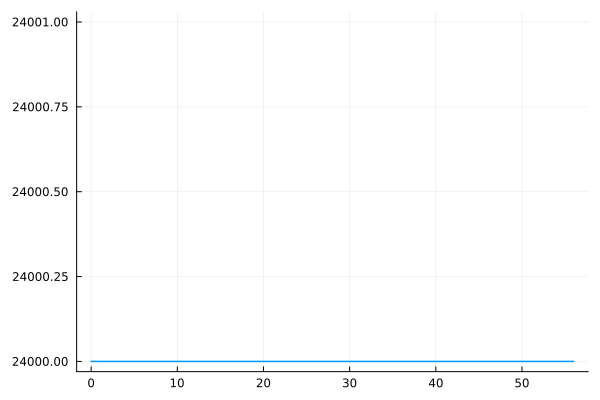

In [11]:
@df mout plot(:t, :X_V)

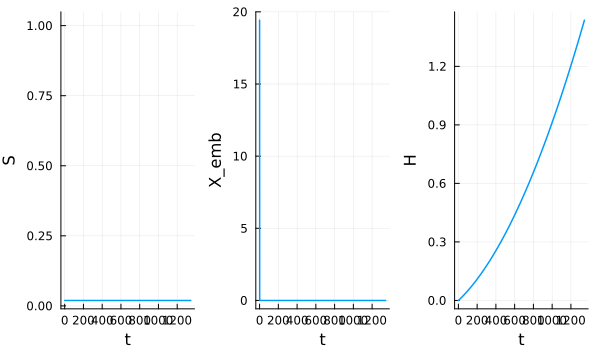

In [12]:
let plotvars = [:S, :X_emb, :H]
    plot(aout.time, Matrix(aout[:,plotvars]), layout = (1,length(plotvars)), ylabel = hcat(plotvars...), xlabel = "t", size = (600,350))
end